In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

chessboard_size = (9, 6)
frame_size = (640, 480)

# 设置棋盘格点的世界坐标
objp = np.zeros((chessboard_size[0]*chessboard_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
square_size = 1
objp *= square_size

# 用于存储世界坐标和图像坐标
objpoints = [] # 3d points in real world space
imgpoints_main = [] # 2d points in image plane

images = glob.glob('demo/left*.jpg')
images = sorted(images)
print(f"Found {len(images)} images for calibration")


for idx, image_file in enumerate(images):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:
        objpoints.append(objp)

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_main.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")

# 相机标定
ret_main, mtx_main, dist_main, rvecs_main, tvecs_main = cv2.calibrateCamera(objpoints, imgpoints_main, frame_size, None, None)
mtx_main, roiL = cv2.getOptimalNewCameraMatrix(mtx_main, dist_main,frame_size, 0)

print(ret_main)
# 0.13074811398820754

# 用于存储世界坐标和图像坐标
imgpoints_side = [] # 2d points in image plane.

images = glob.glob('demo/right*.jpg')
images = sorted(images)
print(f"Found {len(images)} images for calibration")


for idx, image_file in enumerate(images):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_side.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")


# 相机标定
ret_side, mtx_side, dist_side, rvecs_side, tvecs_side = cv2.calibrateCamera(objpoints, imgpoints_side, frame_size, None, None)
mtx_side, roiL = cv2.getOptimalNewCameraMatrix(mtx_side, dist_side,frame_size, 0)

print(ret_side)
# 0.14812752595046502


flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 100, 1e-6)
ret, mtx_main, dist_main, mtx_side, dist_side, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_main, imgpoints_side,
    mtx_main, dist_main, mtx_side, dist_side,
    frame_size, criteria=criteria, flags=flags)

# 立体校正
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtx_main, dist_main, mtx_side, dist_side, frame_size, R, T)

print(ret)

Found 41 images for calibration
0.4079886660635017
Found 41 images for calibration
0.4069743323540327
1.2170125436571109


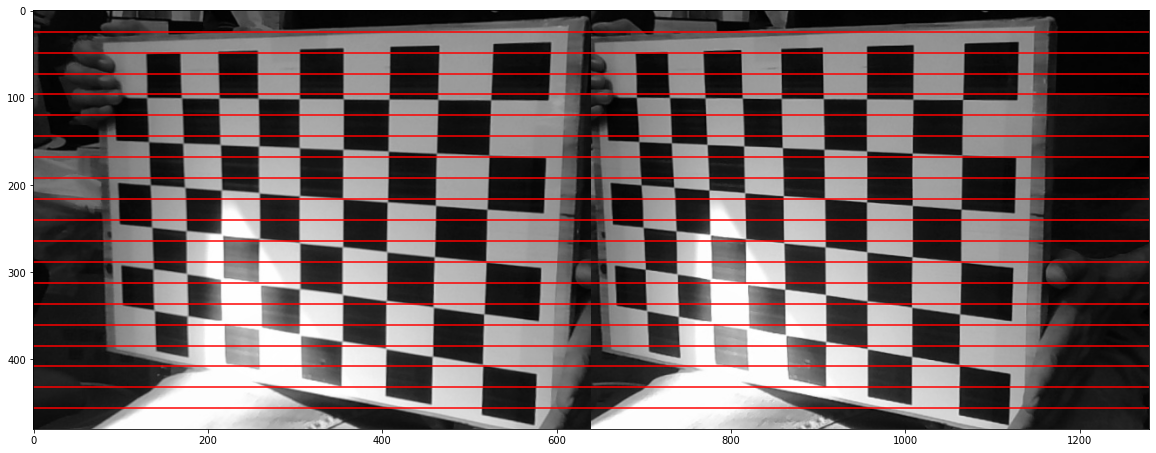

In [3]:
# 对测试图像进行校正
def rectify_image(img, mtx, dist, R, P):
    h, w = img.shape[:2]
    mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, R, P, (w, h), cv2.CV_32FC1)
    return cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# 读取测试图片
img_main = cv2.imread('demo/left03.jpg')
img_side = cv2.imread('demo/right03.jpg')

# 校正图像
rectified_main = rectify_image(img_main, mtx_main, dist_main, R1, P1)
rectified_side = rectify_image(img_side, mtx_side, dist_side, R2, P2)

# 保存校正后的图像
cv2.imwrite('rectified_main.png', rectified_main)
cv2.imwrite('rectified_side.png', rectified_side)

plt.figure(figsize=(20, 20))

for i in range(0,1):  # 以第一对图片为例
    im_L=Image.fromarray(rectified_main) # numpy 转 image类
    im_R=Image.fromarray(rectified_side) # numpy 转 image 类

    width = im_L.size[0]*2
    height = im_L.size[1]

    img_compare = Image.new('RGBA',(width, height))
    img_compare.paste(im_L,box=(0,0))
    img_compare.paste(im_R,box=(640,0))
    
    #在已经极线对齐的图片上均匀画线
    for i in range(1,20):
        len=480/20
        plt.axhline(y=i*len, color='r', linestyle='-')
    plt.imshow(img_compare)
    plt.savefig('epipolar_lines.png', bbox_inches='tight', pad_inches=0)
    plt.show()